# Add the lasa.py file in same directory as the jupyter notebook

In [2]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from lasa import load_lasa
import gmr

from scipy.stats import multivariate_normal


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\sengu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Helper Functions for plotting and loading data

In [3]:
def plot_curves(x,show_start_end=True,**kwargs):
    '''
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    '''
    if show_start_end:
        start_label,end_label = "start","end"
    else:
        start_label,end_label = None,None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0,0],x[t][0,1],c='k',label=start_label)
        plt.scatter(x[t][-1,0],x[t][-1,1],c='b',label=end_label)
        plt.plot(x[t][:,0],x[t][:,1],**kwargs)
        if t==0:
            kwargs.pop("label",None)
            start_label,end_label = None,None

    plt.legend()


def streamplot(f,x_axis=(0,100),y_axis=(0,100),n=1000,width=1,**kwargs):
    '''
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    '''
    a,b = np.linspace(x_axis[0],x_axis[1],n),np.linspace(y_axis[0],y_axis[1],n)
    X,Y = np.meshgrid(a,b)
    X_test = np.stack([X,Y],axis=-1).reshape(-1,2)
    Y_pred = f(X_test)
    U,V = np.split(Y_pred.reshape(n,n,2),2,axis=-1)
    U,V = U[...,0],V[...,0]
    speed = np.sqrt(U**2+V**2)
    lw = width*speed / speed.max()
    plt.streamplot(X,Y,U,V,linewidth=lw,**kwargs)

#gets the velocity x_dot given x
def derivative(x):
    '''
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    '''
    xds = []

    for i in range(x.shape[0]):
        dt = 1/(x[i].shape[0]-1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt,np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0,np.pi/2,len(xd)))**2
        xd = xd*(v_factor[...,None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd

#loading the data and plotting
def load_data(letter):
    '''
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    '''
    letter2id = dict(c=2,j=6,s=24)
    assert letter.lower() in letter2id
    _,x,_,_,_,_ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1,2)
    xd = xd.reshape(-1,2)
    plt.show()
    return data,x,xd

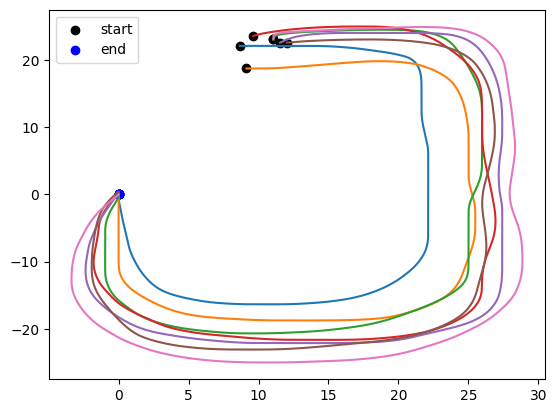

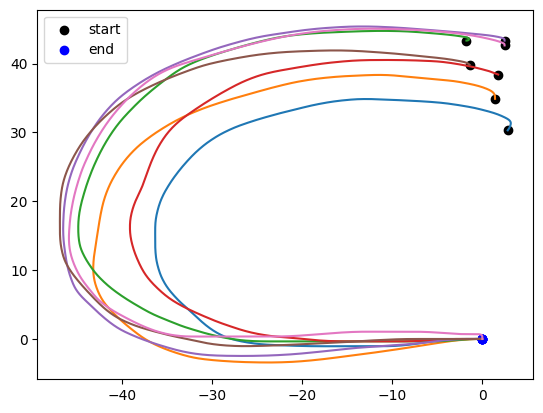

In [4]:
#letter should be one of c,j,s
data,x,xd = load_data("j")
#data,x,xd = load_data("s")
data,x,xd = load_data("c")

# PART1: GMR (Gaussian Mixture Regression)

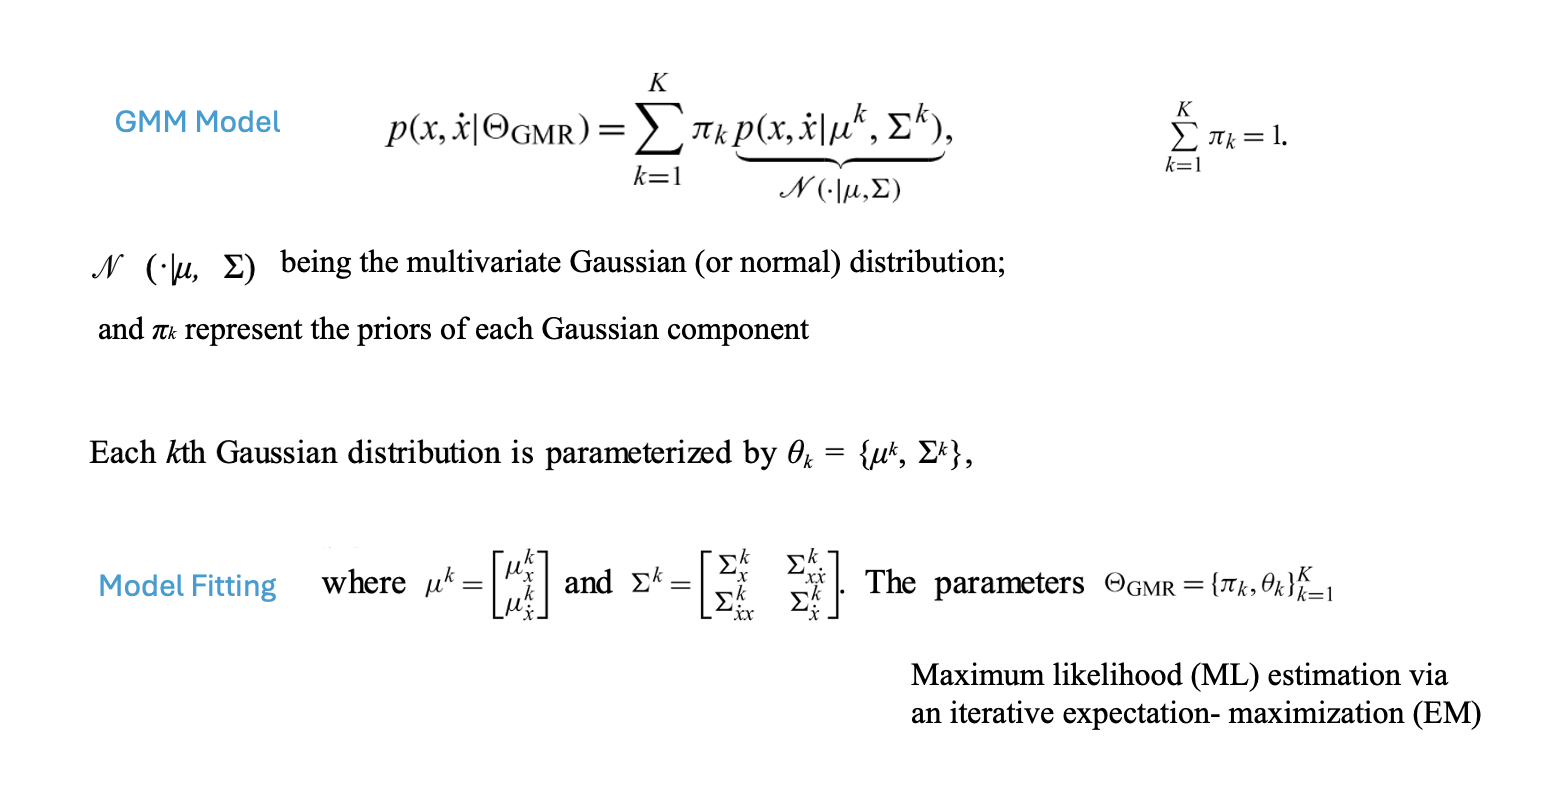

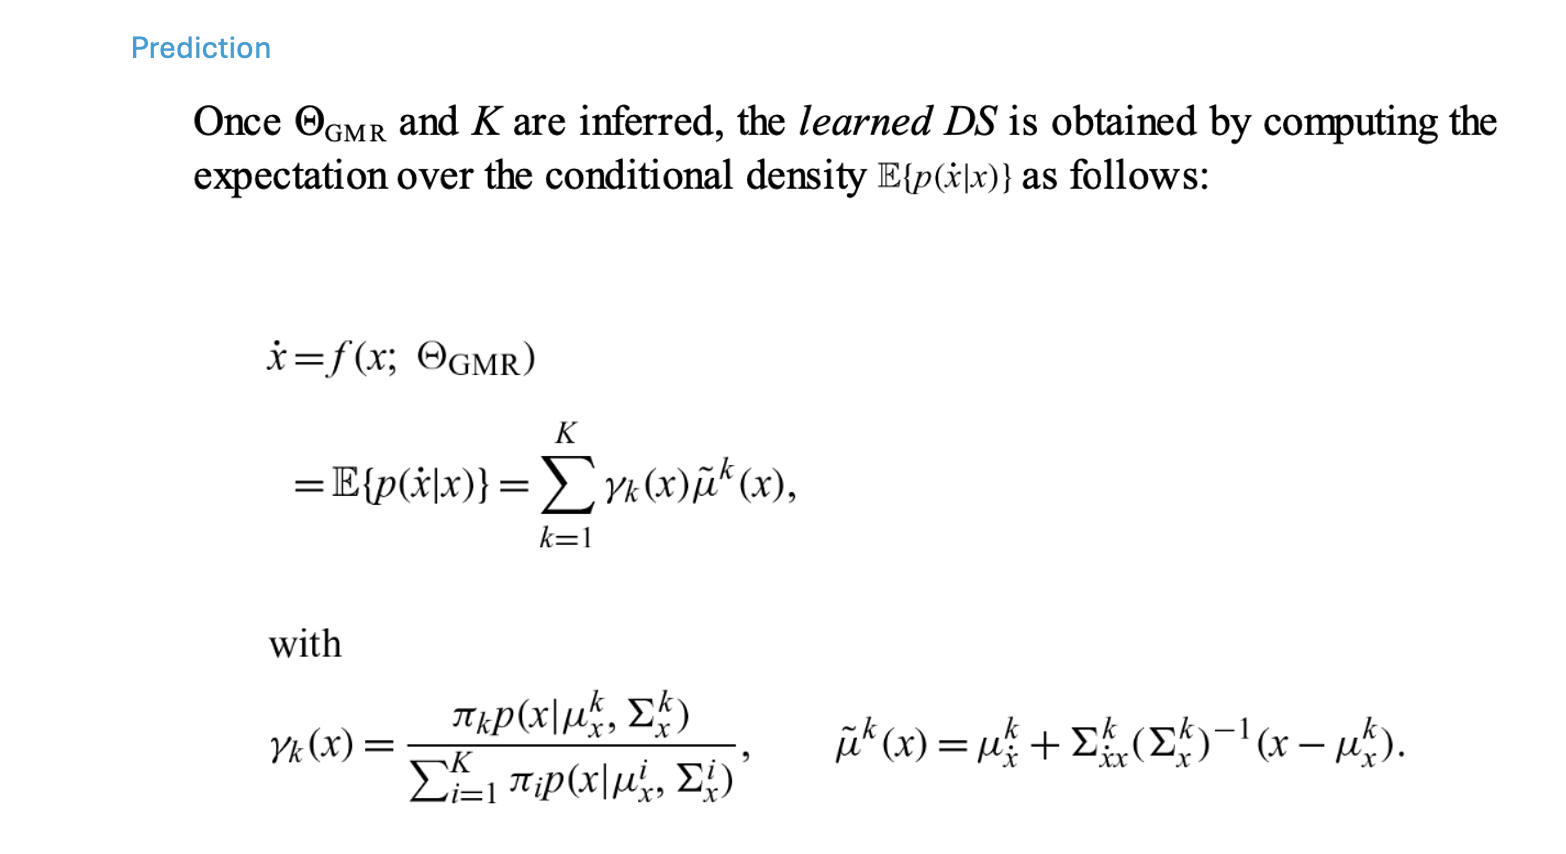

In [ ]:
class GMR:
    def __init__(self, n_components, random_state=1234):
        self.n_components = n_components
        self.random_state = random_state

    def fit(self, X, X_dot):
        '''
        fit the model to the data
        '''
        data = np.hstack([X, X_dot])
        self.gmm = gmr.GMM(n_components=self.n_components, random_state=self.random_state)
        self.gmm.from_samples(data)
        self.priors = self.gmm.priors
        self.means = self.gmm.means
        self.covariances = self.gmm.covariances

    def predict(self, X):
        """
        X: (n_points, 2)
        Returns:
            predicted X_dot: (n_points, 2)
        """

        n_points = X.shape[0]
        n_components = len(self.gmm.priors)

        priors = self.gmm.priors
        means = self.gmm.means
        covs = self.gmm.covariances

        Y_pred = np.zeros((n_points, 2))

        for i, x in enumerate(X):

            weights = np.zeros(n_components)
            cond_means = np.zeros((n_components, 2))

            for k in range(n_components):

                # ---- Split mean ----
                mu_x = means[k][:2]
                mu_y = means[k][2:]

                # ---- Split covariance ----
                Sigma = covs[k]
                Sigma_xx = Sigma[:2, :2]
                Sigma_xy = Sigma[:2, 2:]
                Sigma_yx = Sigma[2:, :2]
                Sigma_yy = Sigma[2:, 2:]

                # ---- Compute Gaussian density p(x|k) ----
                diff = x - mu_x
                inv_Sigma_xx = np.linalg.inv(Sigma_xx)
                det_Sigma_xx = np.linalg.det(Sigma_xx)

                norm_const = 1.0 / np.sqrt((2*np.pi)**2 * det_Sigma_xx)
                exp_term = np.exp(-0.5 * diff.T @ inv_Sigma_xx @ diff)

                px_given_k = norm_const * exp_term

                weights[k] = priors[k] * px_given_k

                # ---- Conditional mean ----
                cond_means[k] = (
                    mu_y
                    + Sigma_yx @ inv_Sigma_xx @ diff
                )

            # ---- Normalize weights ----
            weights /= np.sum(weights)

            # ---- Weighted sum ----
            Y_pred[i] = np.sum(weights[:, None] * cond_means, axis=0)

        return Y_pred


    def ode_differential(self,x,t):
        '''
        function used for rk4 simulation
        '''
        return self.predict(x[None])[0]

    def rk4_sim(self,t0,t_end,x0,f,dt=1e-3):
        '''
        simlution done with rk4
        
        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        '''
        x,t = x0,t0
        x_list,t_list = [x0],[t0]
        while t<=t_end:
            k1 = dt*f(x,t)
            k2 = dt*f(x+k1/2.,t+dt/2. )
            k3 = dt*f(x+k2/2.,t+dt/2. )
            k4 = dt*f(x+k3 , t+dt )
            x = x + 1./6*(k1+2*k2+2*k3+k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)
        return np.array(x_list),np.array(t_list)

    def imitate(self,x0,t_end=5):
        '''
        imitation with new starting point
        
        Parameters
        ----------
        x0  - starting point - shape (self.d,)
        
        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        '''
        f = self.ode_differential
        return self.rk4_sim(0,t_end,x0,f)

In [6]:
#fitting the model to data
model = GMR(10)
model.fit(x,xd)


In [7]:

#starting point for imitation
x0 = data[0][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=10)

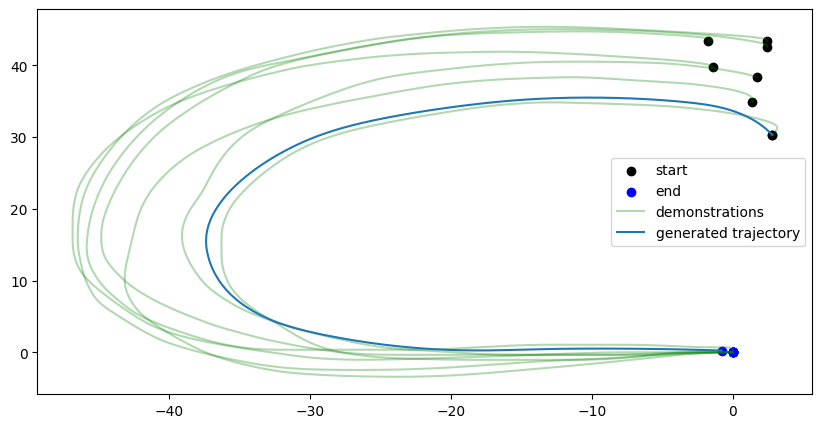

In [8]:

#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")


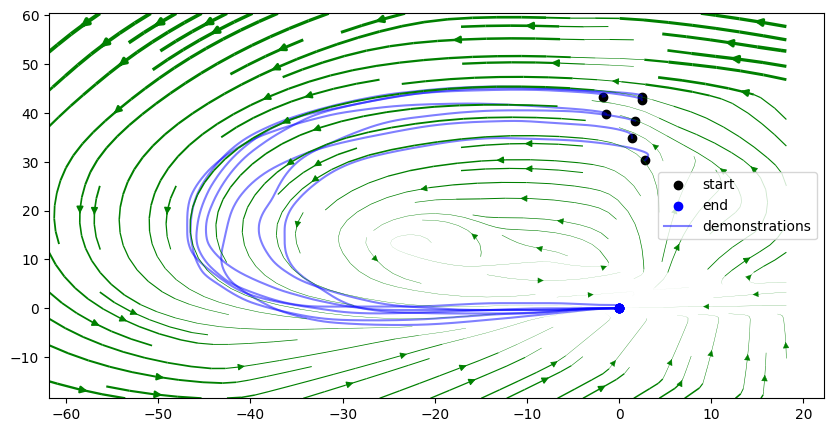

In [9]:
#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.5,c="b",label="demonstrations")
streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g")

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: GMR provides local stability near the demonstrations but not have a GAS. For the C dataset, some trajectories clearly converge to the endpoint within the demonstration region, while some trajectories diverge out of the endpoint/equilibrium. Global stability is also not guaranteed mathematically.

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans: K=3 is too simple (underfitting), missing the curve. K=20 introduces wiggles (overfitting). K=10 is a good balance.

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: 'J' has an unstable sink at the end. Some vectors converge while others diverge away. The vector field directs flow along the J shape. Far from data, behavior is undefined/determined by nearest Gaussian. So, we can say this system does not have a GAS.

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans: Higher curvature of J requires sufficient K (e.g. 10) to capture the hook. Too many K causes overfitting.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: 'S' is more complex. GMR successfully models the S-curve flow. Convergence to the end point is observed for points near the path. But some vector fields to the top of the graph shown do not converge so we can say it does not have a GAS.

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans: S shape is complex; low K (3 or 5) fails to capture both curves. Higher K (10-15) is needed for good generalization without overfitting.


--- Analysis for Dataset C ---


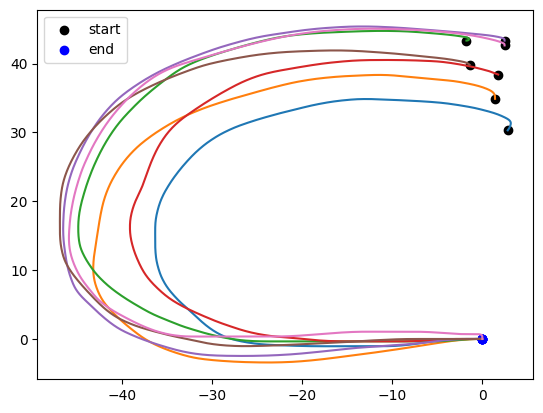

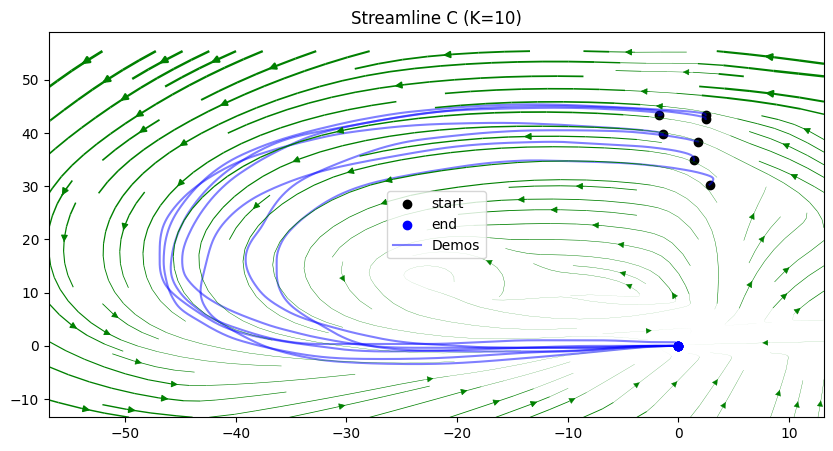

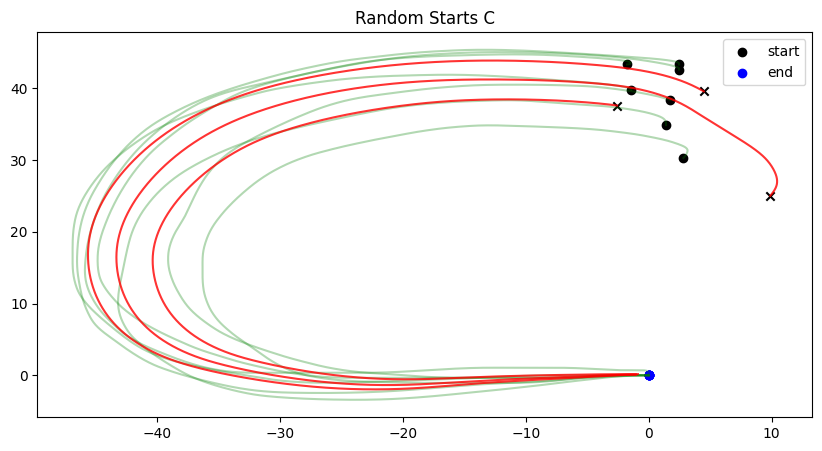

C:\Users\sengu\AppData\Local\Temp\ipykernel_10408\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


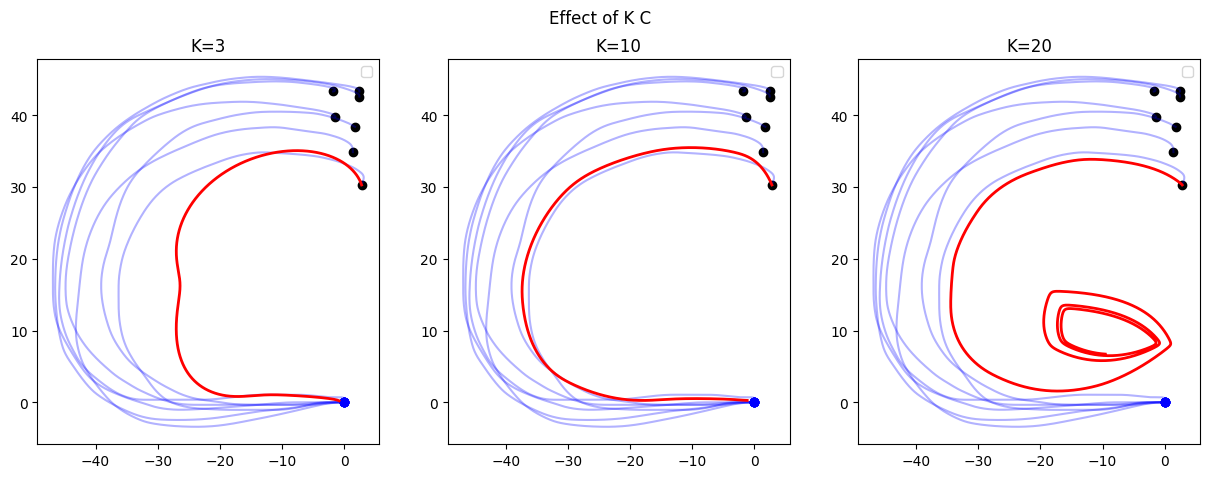

--- Analysis for Dataset J ---


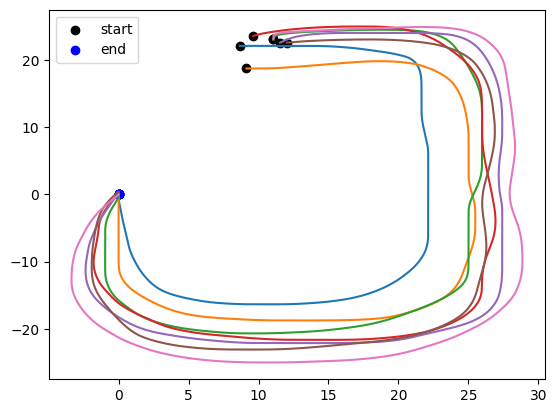

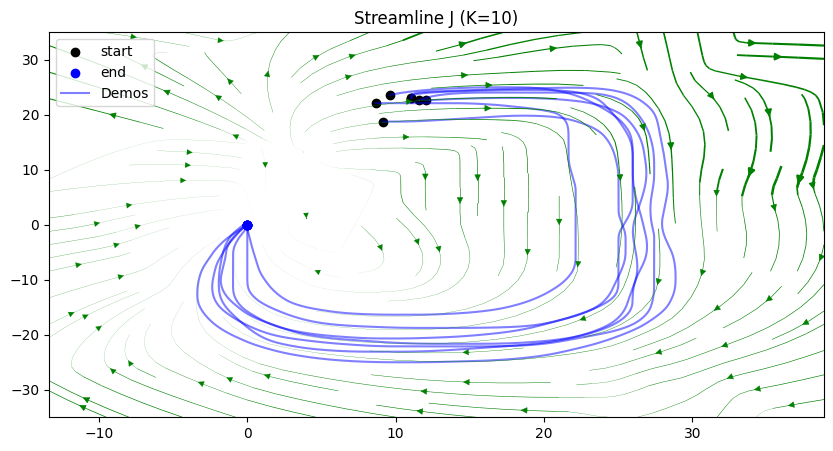

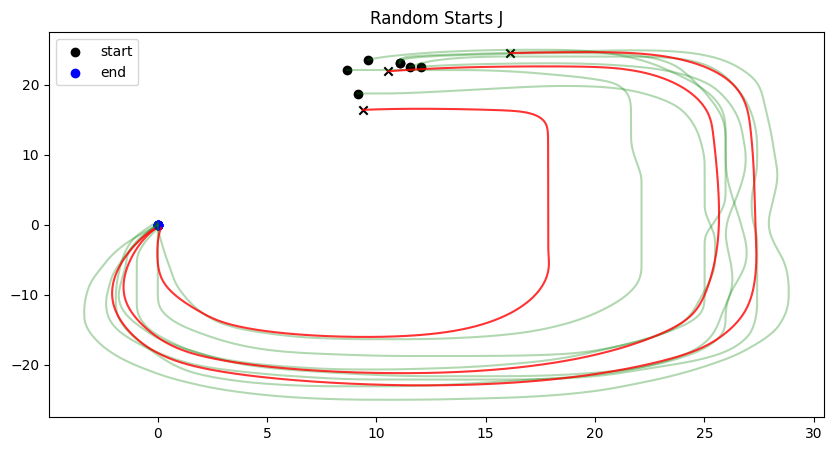

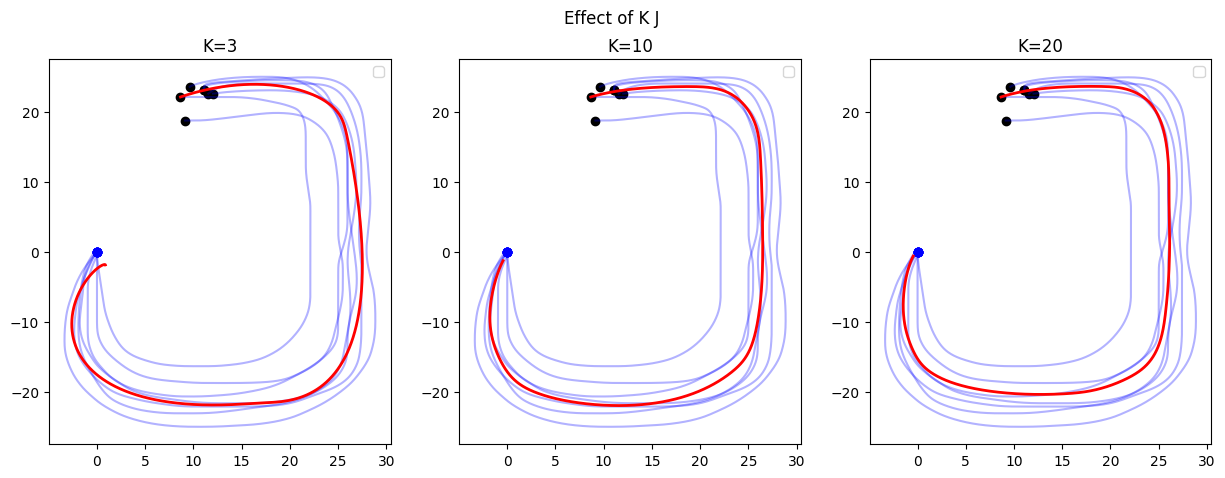

--- Analysis for Dataset S ---


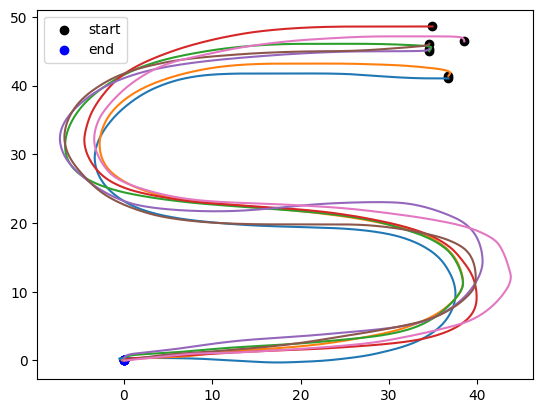

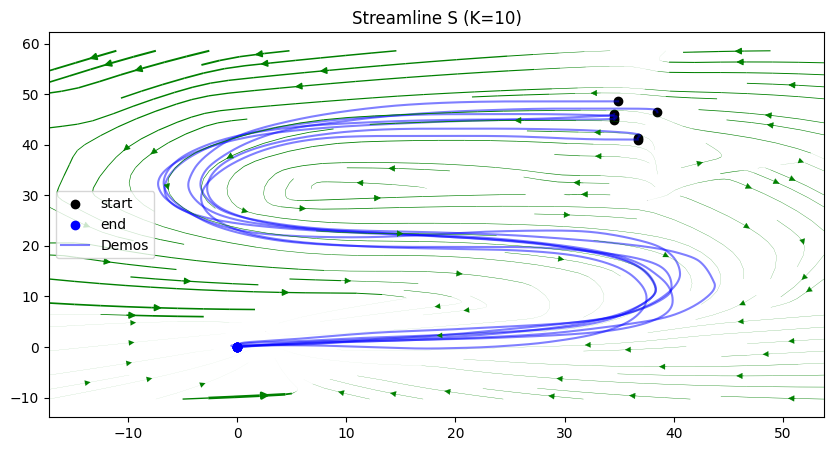

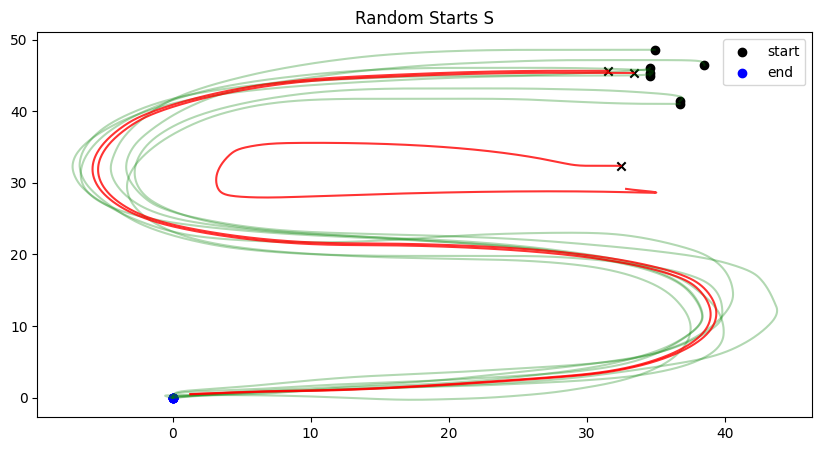

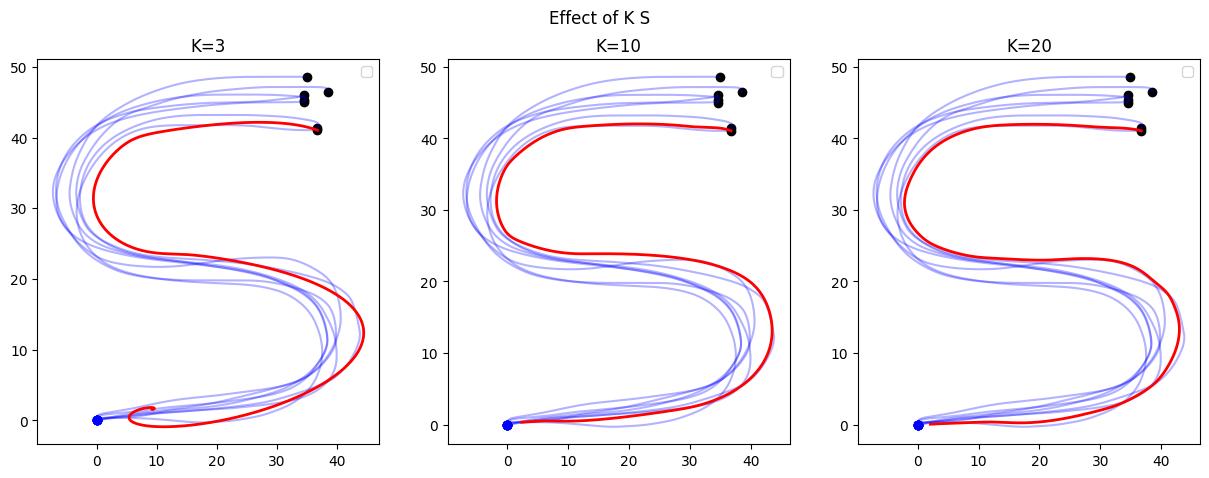

In [32]:
for letter in ['c', 'j', 's']:
    print(f"--- Analysis for Dataset {letter.upper()} ---")
    data_l, x_l, xd_l = load_data(letter)
    
    # Stability
    model_l = GMR(n_components=10)
    model_l.fit(x_l, xd_l)
    
    plt.figure(figsize=(10, 5))
    plt.title(f"Streamline {letter.upper()} (K=10)")
    plot_curves(data_l, alpha=0.5, c="b", label="Demos")
    arr_x = x_l[:, 0]; arr_y = x_l[:, 1]
    x_range = (np.min(arr_x)-10, np.max(arr_x)+10)
    y_range = (np.min(arr_y)-10, np.max(arr_y)+10)
    streamplot(model_l.predict, x_axis=x_range, y_axis=y_range, width=2, color="g")
    plt.show()
    
    # Initial Points
    plt.figure(figsize=(10, 5))
    plt.title(f"Random Starts {letter.upper()}")
    plot_curves(data_l, alpha=0.3, c="g")
    for _ in range(3):
        x0_noisy = data_l[0][0] + np.random.normal(0, 5, 2)
        x_sim, _ = model_l.imitate(x0_noisy, t_end=10)
        plt.plot(x_sim[:, 0], x_sim[:, 1], 'r-', alpha=0.8)
        plt.scatter(x_sim[0, 0], x_sim[0, 1], c='k', marker='x')
    plt.show()
    
    # Number of Gaussians
    plt.figure(figsize=(15, 5))
    for i, K in enumerate([3, 10, 20]):
        plt.subplot(1, 3, i+1)
        m_k = GMR(n_components=K)
        m_k.fit(x_l, xd_l)
        plot_curves(data_l, alpha=0.3, c="b", show_start_end=False)
        x_sim, _ = m_k.imitate(data_l[0][0], t_end=8)
        plt.plot(x_sim[:, 0], x_sim[:, 1], 'r-', linewidth=2)
        plt.title(f"K={K}")
    plt.suptitle(f"Effect of K {letter.upper()}")
    plt.show()


# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment5.ipynb**